In [87]:
import keras
import numpy as np
import pandas as pd
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import language_tool_python
import scipy.stats as stats

tool = language_tool_python.LanguageTool('en-US')
is_bad_rule = lambda rule: rule.message == 'Possible spelling mistake found.' and len(rule.replacements) and \
                           rule.replacements[0][0].isupper()

## Transfer key_times.csv into same format of fixed_text_typing_dataset.csv

In [88]:
import pandas as pd

# Step 1: Read the CSV
df = pd.read_csv('key_times.csv')

# Step 2: Preprocess Data
# Replace 'Key.space' with ' ', 'Key.backspace' with '\b', etc.
df['key'] = df['key'].replace({'Key.space': ' ', 'Key.backspace': '\b', 'Key.enter': '\n'})

# Initialize new DataFrame with the required columns
new_df_columns = ['userId', 'emotionIndex', 'index', 'keyCode', 'keyDown', 'keyUp', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3', 'answer']
new_df = pd.DataFrame(columns=new_df_columns)

# Variables to keep track of previous and next events
previous_down = None
previous_up = None
next_down = None
next_up = None
after_next_down = None
after_next_up = None

# Step 3: Calculate Time Differences and Fill New DataFrame
for i, row in df.iterrows():
    keyCode = row['key']
    keyDown = row['down']
    keyUp = row['up']
    
    # Calculate D1U1 (current down to current up)
    D1U1 = keyUp - keyDown
    
    # Placeholder values for other calculations
    D1U2, D1D2, U1D2, U1U2, D1U3, D1D3 = [None] * 6
    
    if i > 0:  # If not the first row, calculate values involving previous key
        D1D2 = keyDown - previous_down
        U1D2 = keyDown - previous_up
        U1U2 = keyUp - previous_up
    
    if i < len(df) - 1:  # If not the last row, look ahead to calculate future values
        next_row = df.iloc[i + 1]
        next_down = next_row['down']
        next_up = next_row['up']
        D1U2 = next_up - keyDown
        D1U3 = next_up - keyDown  # Placeholder, needs adjustment for "key after next"
    
    # For D1D3, need to look two keys ahead, which requires additional logic not shown here
    
    # Append row to new DataFrame
    new_row = {'userId': 100, 'emotionIndex': 'N', 'index': i, 'keyCode': keyCode, 'keyDown': keyDown, 'keyUp': keyUp, 'D1U1': D1U1, 'D1U2': D1U2, 'D1D2': D1D2, 'U1D2': U1D2, 'U1U2': U1U2, 'D1U3': D1U3, 'D1D3': D1D3, 'answer': None}
    new_df = new_df.append(new_row, ignore_index=True)
    
    # Update previous events
    previous_down = keyDown
    previous_up = keyUp

# Step 4: Export to CSV
new_df.to_csv('extended_key_times.csv', index=False)

In [89]:
import pandas as pd

# Step 1: Read the CSV
df = pd.read_csv('key_times.csv')

# Step 2: Preprocess Data
df['key'] = df['key'].replace({'Key.space': ' ', 'Key.backspace': '\b', 'Key.enter': '\n'})

# Initialize new DataFrame with the required columns
new_df_columns = ['userId', 'emotionIndex', 'index', 'keyCode', 'keyDown', 'keyUp', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3', 'answer']
new_df = pd.DataFrame(columns=new_df_columns)

# Step 3: Calculate Time Differences and Fill New DataFrame
for i, row in df.iterrows():
    keyCode = row['key']
    keyDown = row['down']
    keyUp = row['up']
    
    # Calculate D1U1 (current down to current up)
    D1U1 = keyUp - keyDown
    
    # Initialize placeholders for other calculations
    D1U2, D1D2, U1D2, U1U2, D1U3, D1D3 = [None] * 6
    
    if i > 0:  # If not the first row, calculate values involving previous key
        D1D2 = keyDown - previous_down
        U1D2 = keyDown - previous_up
        U1U2 = keyUp - previous_up
    
    if i < len(df) - 1:  # If not the last row, look ahead to calculate D1U2
        next_row = df.iloc[i + 1]
        next_down = next_row['down']
        next_up = next_row['up']
        D1U2 = next_up - keyDown
    
    if i < len(df) - 2:  # If there are at least two keys ahead, calculate D1D3 and D1U3
        after_next_row = df.iloc[i + 2]
        after_next_down = after_next_row['down']
        after_next_up = after_next_row['up']
        D1D3 = after_next_down - keyDown
        D1U3 = after_next_up - keyDown
    
    # Append row to new DataFrame
    new_row = {
        'userId': 100, 'emotionIndex': 'N', 'index': i, 'keyCode': keyCode, 
        'keyDown': keyDown, 'keyUp': keyUp, 'D1U1': D1U1, 'D1U2': D1U2, 
        'D1D2': D1D2, 'U1D2': U1D2, 'U1U2': U1U2, 'D1U3': D1U3, 'D1D3': D1D3, 
        'answer': None
    }
    new_df = new_df.append(new_row, ignore_index=True)
    
    # Update previous events
    previous_down = keyDown
    previous_up = keyUp

# Step 4: Export to CSV
new_df.to_csv('extended_key_times1.csv', index=False)

In [90]:
import pandas as pd

# Read the CSV
df = pd.read_csv('key_times.csv')

# Replace 'Key.space' with ' ', 'Key.backspace' with '\b', etc.
df['key'] = df['key'].replace({'Key.space': ' ', 'Key.backspace': '\b', 'Key.enter': '\n'})

# Initialize new DataFrame with the required columns
new_df_columns = ['userId', 'emotionIndex', 'index', 'keyCode', 'keyDown', 'keyUp', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3', 'answer']
new_df = pd.DataFrame(columns=new_df_columns)

# Loop through each row to calculate time differences
for i, row in df.iterrows():
    keyCode = row['key']
    keyDown = row['down']
    keyUp = row['up']
    D1U1 = keyUp - keyDown  # Always calculable
    
    # Initialize placeholders
    D1U2 = D1D2 = U1D2 = U1U2 = D1U3 = D1D3 = None
    
    # Calculate D1U2 if not the last row
    if i < len(df) - 1:
        next_row = df.iloc[i + 1]
        D1U2 = next_row['up'] - keyDown
    
    # Calculate D1D2, U1D2, U1U2 if not the first row
    if i > 0:
        prev_row = df.iloc[i - 1]
        D1D2 = keyDown - prev_row['down']
        U1D2 = keyDown - prev_row['up']
        U1U2 = keyUp - prev_row['up']
    
    # Calculate D1D3, D1U3 if there are at least two more keys ahead
    if i < len(df) - 2:
        after_next_row = df.iloc[i + 2]
        D1D3 = after_next_row['down'] - keyDown
        D1U3 = after_next_row['up'] - keyDown
    
    # Append row to new DataFrame
    new_row = {
        'userId': 100, 'emotionIndex': 'N', 'index': i, 'keyCode': keyCode,
        'keyDown': keyDown, 'keyUp': keyUp, 'D1U1': D1U1, 'D1U2': D1U2,
        'D1D2': D1D2, 'U1D2': U1D2, 'U1U2': U1U2, 'D1U3': D1U3, 'D1D3': D1D3,
        'answer': None
    }
    new_df = new_df.append(new_row, ignore_index=True)

# Export to CSV
new_df.to_csv('data/extended_fixed_key_times2.csv', index=False)

In [91]:
import pandas as pd

# Read the CSV
df = pd.read_csv('key_times.csv')

# Replace specific key values with desired characters
df['key'] = df['key'].replace({'Key.space': ' ', 'Key.backspace': '\b', 'Key.enter': '\n'})

# Initialize new DataFrame with the required columns
new_df_columns = ['userId', 'emotionIndex', 'index', 'keyCode', 'keyDown', 'keyUp', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3', 'answer']
new_df = pd.DataFrame(columns=new_df_columns)

# Loop through each row to calculate time differences
for i, row in df.iterrows():
    keyCode = row['key']
    keyDown = row['down']
    keyUp = row['up']
    D1U1 = keyUp - keyDown  # Always calculable

    # Initialize placeholders
    D1U2 = D1D2 = U1D2 = U1U2 = D1U3 = D1D3 = None

    # Calculate D1U2, D1D2, U1D2, U1U2 if not the last row
    if i < len(df) - 1:
        next_row = df.iloc[i + 1]
        D1U2 = next_row['up'] - keyDown
        D1D2 = next_row['down'] - keyDown
        U1D2 = next_row['down'] - keyUp
        U1U2 = next_row['up'] - keyUp

    # Calculate D1D3, D1U3 if there are at least two more keys ahead
    if i < len(df) - 2:
        after_next_row = df.iloc[i + 2]
        D1D3 = after_next_row['down'] - keyDown
        D1U3 = after_next_row['up'] - keyDown

    # Append row to new DataFrame
    new_row = {
        'userId': 100, 'emotionIndex': 'N', 'index': i, 'keyCode': keyCode,
        'keyDown': keyDown, 'keyUp': keyUp, 'D1U1': D1U1, 'D1U2': D1U2,
        'D1D2': D1D2, 'U1D2': U1D2, 'U1U2': U1U2, 'D1U3': D1U3, 'D1D3': D1D3,
        'answer': None
    }
    new_df = new_df.append(new_row, ignore_index=True)

# Export to CSV
new_df.to_csv('data/extended_fixed_key_times3.csv', index=False)

## Data importation

In [92]:
df_fixed = pd.read_csv('data/fixed_text_typing_dataset.csv', sep=';')
df_freq = pd.read_csv('data/frequency_dataset.csv', sep=';')
df_user = pd.read_csv('data/participants_information.csv', sep=';')

df_freq = df_freq.rename(columns={'User ID': 'userId'})

## Sentences reconstruction and feature extraction

In [93]:
# reconstruct users' sentences from the keycode in df_fixed

sentence = ''
uppercase = False
uppercase_tmp = False
i_start = 0
i_end = 0
text_fixed = pd.DataFrame(columns=['sentence', 'idx_start', 'idx_end'])

df_fixed.keyCode = df_fixed.keyCode.astype(str)

for i in range(len(df_fixed)):
    if i > 0 and (df_fixed.userId[i] != df_fixed.userId[i - 1] or df_fixed.emotionIndex[i] != df_fixed.emotionIndex[
        i - 1]):  #df_fixed._id[i][:-2] != df_fixed._id[i-1][:-2]:
        i_end = i - 1
        if len(text_fixed) == 62:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i + 4] == 'once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start + ids_start[1] - 1]],
                                                        columns=['sentence', 'idx_start', 'idx_end']),
                                           ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[1], i_start + ids_start[2] - 1]],
                             columns=['sentence', 'idx_start', 'idx_end']), ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[2], i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        elif len(text_fixed) == 134 or len(text_fixed) == 190:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i + 4] == 'Once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start + ids_start[1] - 1]],
                                                        columns=['sentence', 'idx_start', 'idx_end']),
                                           ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[1], i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        else:
            if sentence[0].islower() and sentence[1].isupper():
                sentence = sentence.swapcase()
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start, i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        i_start = i
        sentence = ''
        uppercase = False
        uppercase_tmp = False
    if df_fixed.keyCode[i] == '\\b':  # delete key
        sentence = sentence[:max(0, len(sentence) - 1)]
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '\\u0014':  # caps lock key
        uppercase = not uppercase
        continue
    if df_fixed.keyCode[i] == '\\u0010' and not uppercase:  # shift key
        uppercase_tmp = True
        continue
    if df_fixed.keyCode[i] == '¼':  # comma key
        sentence += ','
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == 'ß':  # exclamation mark key
        sentence += '!'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¾':  # dot key
        sentence += '.'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '4    ':  # apostrophe key
        sentence += "'"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '6    ':  # dash key
        sentence += "-"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¿':  # colon key
        sentence += ":"
        uppercase_tmp = False
        continue
    if uppercase:
        sentence += df_fixed.keyCode[i].upper()
        continue
    if uppercase_tmp:
        sentence += df_fixed.keyCode[i].upper()
        uppercase_tmp = False
        continue
    sentence += df_fixed.keyCode[i]

text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i]], columns=['sentence', 'idx_start', 'idx_end']),
                               ignore_index=True)

### Fixed text

In [94]:
# fixed text that users have been asked to write

gold_fixed = {
    'N': 'Once there was a cat and a mouse. Usually, cats eat mice, and mice run away from cats. But this cat and this mouse liked each other very much. They liked each other so much that they lived together.',
    'H': 'We can not help falling in love with cute and funny babies. Their beautiful and joyful laughter makes us happy.',
    'C': 'Beautiful nature and calm music are always relaxing. The soft sounds are so pleasant to listen to. Watching the superb nature calms our body and soul.',
    'S': 'The boy yells at his father to wake him up. But the father is dead. The poor boy is very sad. He realized that his father is gone forever.',
    'A': 'Jake has a horrible temper, especially when he drinks alcohol. He gets andgry and agressive when he is drunk. He savagely  beats and violeates his wife.'
}

In [95]:
# functions to extract features from the df_fixed table
df_fixed = df_fixed.drop(['D1U3', 'D1D3'], axis=1)
df_fixed.head()

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,answer
0,100,N,3448,o,"1,58E+12","1,58E+12",90,2556,2479.0,2389,2466,NaN
1,100,N,3449,n,"1,58E+12","1,58E+12",77,258,131.0,54,181,NaN
2,100,N,3450,c,"1,58E+12","1,58E+12",127,613,519.0,392,486,NaN
3,100,N,3451,e,"1,58E+12","1,58E+12",94,276,200.0,106,182,NaN
4,100,N,3452,,"1,58E+12","1,58E+12",76,2104,2032.0,1956,2028,NaN


In [96]:
def extract_editDistance_fixed(gold_fixed, emotion, sentence):
    return nltk.edit_distance(sentence, gold_fixed[emotion])

#this method is used to calculate the edit distance between two strings
#the edit distance is the number of characters that need to be substituted, inserted, or deleted, to transform one string into another


def extract_nbKeystroke(val, start, end):
    return val[end] - val[start] + 1

#this method is used to calculate the number of keystrokes


def extract_mean(val, start, end):
    return np.mean(val[start:end + 1])
#this method is used to calculate the mean of the values

def extract_std(val, start, end):
    return np.std(val[start:end + 1])
#this method is used to calculate the standard deviation of the values

def extract_answer(val, start, end):
    for i in range(start, end + 1):
        if val[i] != np.nan:
            return val[i]
    return np.nan
#this method is used to extract the answer from the values

In [97]:
# key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']
# 
# text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
# text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
# text_fixed = text_fixed.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
# text_fixed['editDistance'] = text_fixed.apply(
#     lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
# text_fixed['nbKeystroke'] = text_fixed.apply(
#     lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
# text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)
# 
# for feat in key_features:
#     df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
#     text_fixed[feat + '_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']),
#                                                   axis=1)
#     text_fixed[feat + '_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']),
#                                                  axis=1)
# 
# text_fixed.head()


# altered due to ufunc error: UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.StrDType'> -> None

# Convert the key features columns to numeric, setting errors='coerce' to convert non-numeric values to NaN

key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']

for feat in key_features:
    df_fixed[feat] = pd.to_numeric(df_fixed[feat], errors='coerce')

    # Rest of your code
text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
text_fixed = text_fixed.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
text_fixed['editDistance'] = text_fixed.apply(
    lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
text_fixed['nbKeystroke'] = text_fixed.apply(
    lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)

# Apply the lambda function
for feat in key_features:
    df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
    text_fixed[feat + '_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']),
                                                  axis=1)
    text_fixed[feat + '_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']),
                                                 axis=1)

text_fixed.head()



,idx_start,idx_end,userId,emotionIndex,sentence,editDistance,nbKeystroke,answer,D1U1_mean,D1U1_std,D1U2_mean,D1U2_std,D1D2_mean,D1D2_std,U1D2_mean,U1D2_std,U1U2_mean,U1U2_std
0,0,282,100,N,"once there was a cat and a mouse. usually , ca...",26,283,NaN,96.074380,31.715592,884.215768,1157.264475,683.060284,1101.553201,694.609959,1157.337134,677.178571,1108.432937
1,283,422,100,H,We can not help falling in love with cute and ...,2,140,R,99.071429,22.182246,813.769784,701.131104,714.784173,699.459223,615.776978,696.222821,714.762590,697.865776
2,423,656,113,N,Once there was a cat and a mouse\u0010. Usaual...,23,234,NaN,88.440171,35.663291,449.802575,381.758170,361.309013,379.970339,272.832618,380.091995,361.326180,381.705475
3,657,840,113,C,Beautiful nature and calm music are always rel...,2,184,R,92.587571,51.886713,526.255682,613.476557,426.710383,601.426508,347.096591,614.503538,421.160221,614.552941
4,841,978,113,H,We can not help falling in love with cute and ...,2,138,R,92.086957,54.058138,443.934307,332.686657,352.138686,325.048838,260.189781,325.204406,351.985401,332.486627


[]

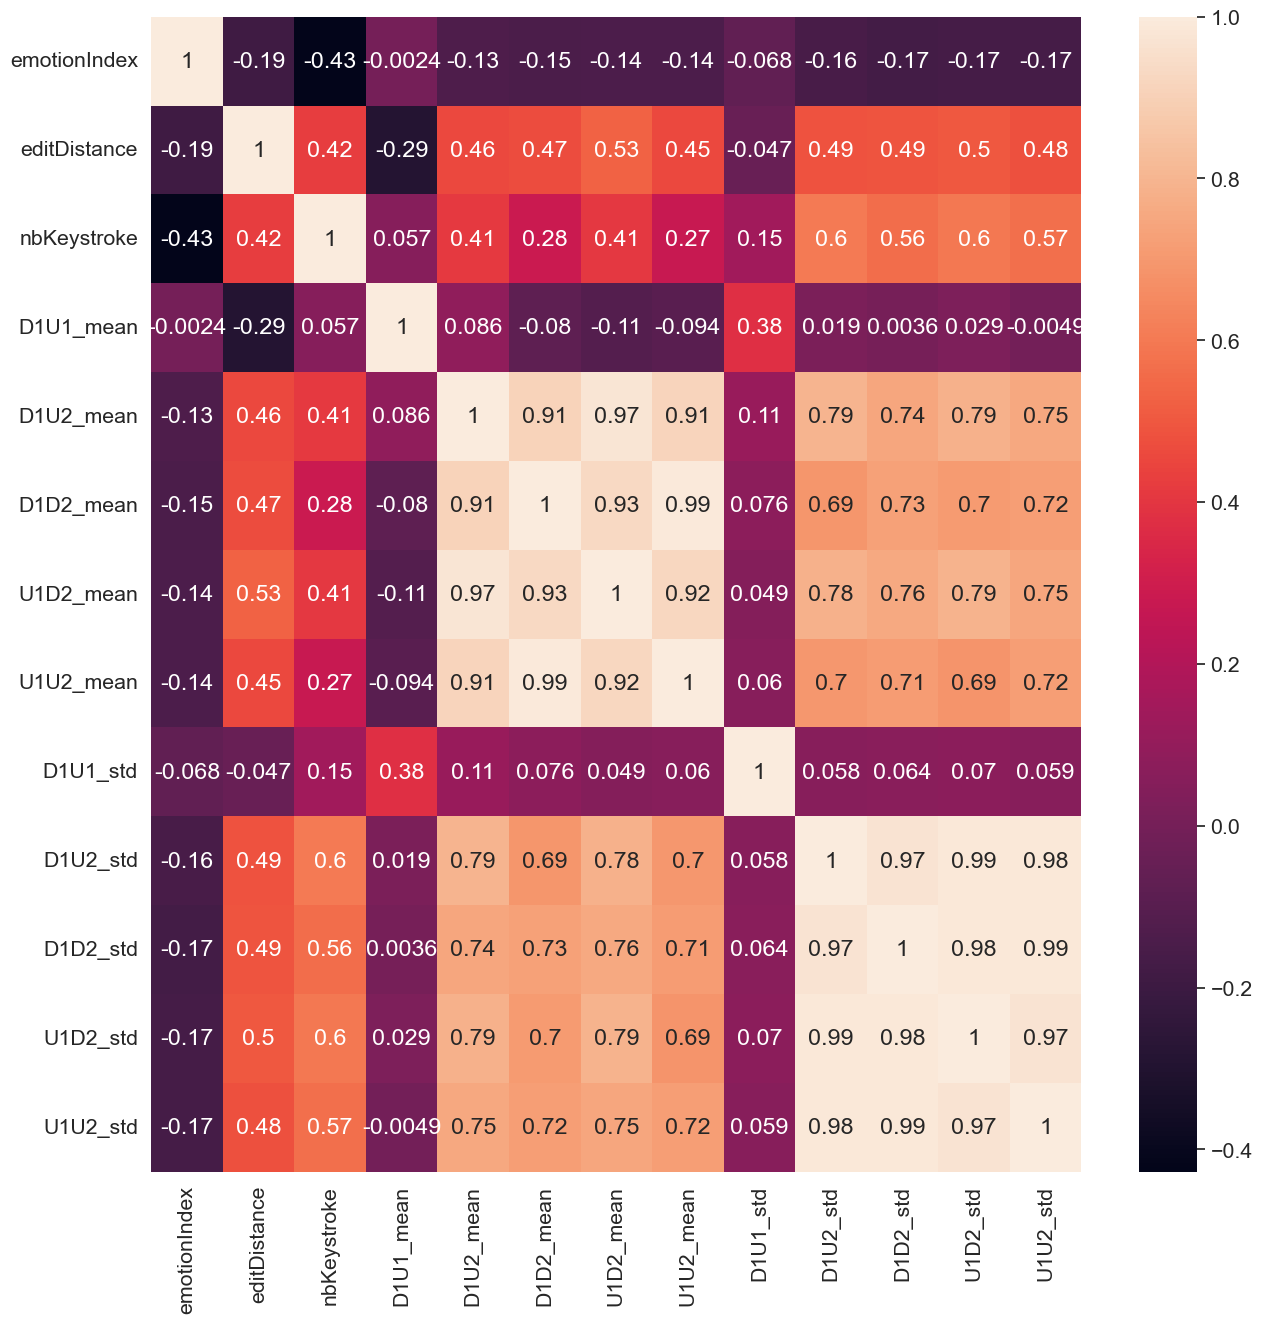

In [98]:
## correlation matrix

# Numeric columns of the dataset
text_fixed.emotionIndex = text_fixed.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
numeric_col = ['emotionIndex', 'editDistance', 'nbKeystroke'] + [col for col in text_fixed.columns if
                                                                 '_mean' in col] + [col for col in text_fixed.columns if
                                                                                    '_std' in col]

# Correlation Matrix formation
corr_matrix = text_fixed.loc[:, numeric_col].corr()
text_fixed.emotionIndex = text_fixed.emotionIndex.map({0: 'N', 1: 'H', 2: 'C', 3: 'S', 4: 'A'})

#Using heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 15))
sn.heatmap(corr_matrix, annot=True)
plt.plot()

## Join tables: text_fixed with df_freq_fixed

In [99]:
# filter fixed-text experiments in df_freq
df_freq_fixed = df_freq[df_freq.textIndex == 'FI'].reset_index(drop=True)
#this method is used to reset the index of the DataFrame

In [100]:
# correction of expections to align df_freq_fixed and text_fixed tables
text_fixed.loc[44, 'userId'] = 94
tmp = text_fixed.loc[30]
text_fixed.loc[30] = text_fixed.loc[31]
text_fixed.loc[31] = tmp

In [101]:
# alignment of df_freq_fixed and text_fixed tables
text_fixed['text_index'] = -1
df_freq_fixed['text_index'] = -1
index = 0

i = 0
j = 0
while i < len(df_freq_fixed) and j < len(text_fixed):
    if df_freq_fixed.userId[i] == text_fixed.userId[j] and df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i, 'text_index'] = index
        text_fixed.loc[j, 'text_index'] = index
        index += 1
        i += 1
        j += 1
    elif j != len(text_fixed) - 1 and df_freq_fixed.userId[i] == text_fixed.userId[j + 1] and \
            df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j + 1]:
        df_freq_fixed.loc[i, 'text_index'] = index
        text_fixed.loc[j + 1, 'text_index'] = index
        index += 1
        i += 1
        j += 2
    elif i != len(df_freq_fixed) - 1 and df_freq_fixed.userId[i + 1] == text_fixed.userId[j] and \
            df_freq_fixed.emotionIndex[i + 1] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i + 1, 'text_index'] = index
        text_fixed.loc[j, 'text_index'] = index
        index += 1
        i += 2
        j += 1
    else:
        i += 1
        j += 1

In [102]:
# correction of expections to align df_freq_fixed and df_user tables
tmp = df_user.loc[92]
df_user.loc[92] = df_user.loc[91]
df_user.loc[91] = tmp

In [103]:
## alignment of df_freq_index and df_user tables
df_freq_fixed['user_index'] = -1
index = 0

j = 0
for i in range(len(df_freq_fixed)):
    if i in [39, 59, 71, 145, 156, 159, 179, 235]:
        j += 1
    if j < len(df_user) and df_freq_fixed.userId[i] == df_user.userId[j]:
        df_freq_fixed.loc[i, 'user_index'] = j
        i += 1
    else:
        if j < len(df_user) - 1 and df_freq_fixed.userId[i] == df_user.userId[j + 1]:
            df_freq_fixed.loc[i, 'user_index'] = j + 1
            i += 1
            j += 1
        else:
            for k in range(1, 6):
                if df_freq_fixed.userId[i] == df_freq_fixed.userId[i - k]:
                    df_freq_fixed.loc[i, 'user_index'] = df_freq_fixed.loc[i - k, 'user_index']
                    break

In [104]:
# merge all tables
df_fixed_all = df_freq_fixed.join(text_fixed, on='text_index', how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['userId_right', 'emotionIndex_right', 'text_index_right'], axis=1)
df_fixed_all = df_fixed_all.join(df_user.reset_index().rename(columns={'index': 'user_index'}), on='user_index',
                                 how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['user_index_right', 'userId_right'], axis=1)
df_fixed_all.head()

#df_fixed_all is the final DataFrame that contains all the information, that was built by joining the tables df_freq_fixed, text_fixed and df_user by using indexes that suit the sentences that were answered by the users

,userId,textIndex,emotionIndex,delFreq,leftFreq,TotTime,text_index,user_index,idx_start,idx_end,...,U1U2_mean,U1U2_std,typeWith,typistType,pcTimeAverage,ageRange,gender,status,degree,country
0,100,FI,N,8,1,192762.0,0,0,0,282,...,677.178571,1108.432937,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
1,100,FI,H,11,0,99463.0,1,0,283,422,...,714.762590,697.865776,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
2,113,FI,N,10,0,84265.0,2,1,423,656,...,361.326180,381.705475,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
3,113,FI,C,7,0,78186.0,3,1,657,840,...,421.160221,614.552941,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
4,113,FI,H,9,0,48354.0,4,1,841,978,...,351.985401,332.486627,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia


## Data analysis

### Useful functions

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from tqdm import trange

In [106]:
# Receiving a dictionary of performance metrics and printing them
def show_metrics(performance_metrics):
    for metric_name, metric in performance_metrics.items():
        if metric_name.startswith("Confusion"):
            print("Confusion Matrix: ")
            if len(metric) != 5:
                print(pd.DataFrame(metric))
            else:
                print(pd.DataFrame(metric,
                                   index=list(label_dictionary.values()),
                                   columns=list(label_dictionary.values())))
        else:
            print("Metric : % s, Score : % 5.2f" % (metric_name, metric))

In [107]:
# Plotting the Confusion Matrix as a heatmap
label_dictionary = {1: 'N', 2: 'H', 3: 'C', 4: 'S', 5: 'A'}


def plot_confusion_matrix(confusion_matrix):
    if len(confusion_matrix) != 5:
        df_cm = pd.DataFrame(confusion_matrix)
    else:
        df_cm = pd.DataFrame(confusion_matrix,
                             index=[i for i in label_dictionary.values()],
                             columns=[i for i in label_dictionary.values()])
    plt.figure()
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.show()

In [108]:
# Computing the different Performance Metrics
def compute_metrics(clf, dataX, dataY, show=False):
    # Using Confusion Metrics to compute metrics
    def performance_measures(y_true, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        acc = np.mean((TP + TN) / (TP + FP + FN + TN))
        TP_rate = np.mean(TP / (TP + FN))
        FP_rate = np.mean(FP / (FP + TN))
        precision = np.mean(TP / (TP + FP))
        f_measure = 2 * precision * TP_rate / (precision + TP_rate)
        f_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f_macro = metrics.f1_score(y_true, y_pred, average='macro')

        # Returning 
        return (acc, TP_rate, FP_rate, precision, f_measure, f_micro, f_macro,
                np.round(cnf_matrix, 2))

    acc, tp_rate, fp_rate, precision, f_measure, f_micro, f_macro, confusion_matrix = performance_measures(y_true=dataY,
                                                                                                           y_pred=clf.predict(
                                                                                                               dataX))

    performance_metrics = {"ACC": acc, "TP_Rate": tp_rate, "FP_Rate": fp_rate,
                           "Precision": precision, "F_Measure": f_measure, "F_Micro": f_micro, "F_Macro": f_macro,
                           "Confusion Matrix": confusion_matrix}
    if show:
        show_metrics(performance_metrics)

    return performance_metrics

### Data pre-processing

In [109]:
data_fixed = df_fixed_all.loc[:, df_fixed_all.columns.difference(
    ['user_index', 'emotionIndex', 'userId', 'textIndex', 'text_index', 'idx_start', 'idx_end', 'sentence'])]
#loc method is a method that takes only index labels and returns the rows of the dataframe
label_fixed = df_fixed_all.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
# 

In [110]:
# convert categorical features into numerical features
data_fixed.gender = (data_fixed.gender == 'Male')
data_fixed.ageRange = data_fixed.ageRange.map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
data_fixed.answer = data_fixed.answer.map({'R': 1, 'W': 0})
data_fixed.degree = data_fixed.degree.map({'High School': 1, 'College/University': 2})
data_fixed.pcTimeAverage = data_fixed.pcTimeAverage.map(
    {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
data_fixed.status = data_fixed.status.map({'Student': 1, 'Professional': 2})
data_fixed.typeWith = data_fixed.typeWith.map({'1 hand': 1, '2 hands': 2})
data_fixed = pd.get_dummies(data_fixed, columns=['country', 'typistType'])
data_fixed = data_fixed.fillna(-1)
#fillna method (-1) means that the missing values (NaN) are replaced by -1

In [111]:
data_fixed_filter = data_fixed
features = data_fixed_filter.columns.tolist()
print(features)
print(len(features))
#label_fixed = (label_fixed == 1)  ## for binary models

['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
41


### Statistical analysis

In [112]:
data_fixed.D1U2_mean.describe()

count     243.000000
mean      527.396707
std       265.232255
min        -1.000000
25%       382.898585
50%       461.966216
75%       577.206529
max      2831.904167
Name: D1U2_mean, dtype: float64

In [113]:
# only for demographic features
# , 'country', 'typistType'

test_columns = ['D1U2_mean', 'D1D2_mean', 'D1D2_mean', 'U1D2_mean']
personal_col = ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status']
for column in test_columns:
    for col in personal_col:
        anova = stats.f_oneway(data_fixed.loc[data_fixed[column] < 383, col],
                               data_fixed.loc[(data_fixed[column] >= 383) & (data_fixed[column] < 462), col],
                               data_fixed.loc[(data_fixed[column] >= 462) & (data_fixed[column] < 577), col],
                               data_fixed.loc[data_fixed[column] >= 577, col])
        print(col + ': ' + str(anova))

typeWith: F_onewayResult(statistic=1.0625981968164069, pvalue=0.3656656135760937)
gender: F_onewayResult(statistic=0.756571665449794, pvalue=0.5195069267139663)
ageRange: F_onewayResult(statistic=0.9274717411270018, pvalue=0.4281108442943713)
degree: F_onewayResult(statistic=0.5685627041613412, pvalue=0.6362275327388702)
pcTimeAverage: F_onewayResult(statistic=1.6099404272995905, pvalue=0.1877059793560212)
status: F_onewayResult(statistic=1.999588159091468, pvalue=0.11471258141355706)
typeWith: F_onewayResult(statistic=0.19334546370631087, pvalue=0.9008717295902245)
gender: F_onewayResult(statistic=0.3654624110050236, pvalue=0.7780002578658874)
ageRange: F_onewayResult(statistic=1.33024615974079, pvalue=0.26515452912006854)
degree: F_onewayResult(statistic=0.2681775674212019, pvalue=0.8483045927322145)
pcTimeAverage: F_onewayResult(statistic=1.5907019558837678, pvalue=0.19226733253030542)
status: F_onewayResult(statistic=0.6107938109828985, pvalue=0.6086008444504862)
typeWith: F_oneway

### Multi-class models

In [114]:
#define classification models
classifiers_name = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg',
                       class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False),
    SVC(kernel='rbf', decision_function_shape='ovr', probability=True),  #, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    MLPClassifier(alpha=1, max_iter=500)]

In [115]:
# comment in afterwards

# micro-F1 scores with a 10-fold cross-validation method

#model_scores_micro = {}
#for i in range(len(classifiers)):
#    model_scores_micro[classifiers_name[i]] = []
#    print(classifiers_name[i])
#    for j in range(10):
#        model = classifiers[i]
#        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1,
#                                                 scoring='f1_micro')
#        model_scores_micro[classifiers_name[i]] += list(scores)
#    mean = np.nanmean(model_scores_micro[classifiers_name[i]])
#    std = np.nanstd(model_scores_micro[classifiers_name[i]])
#    model_scores_micro[classifiers_name[i]] = [mean, std]

#model_scores_micro

In [116]:
# comment in afterwards

# macro-F1 scores with a 10-fold cross-validation method

#model_scores_macro = {}
#for i in range(len(classifiers)):
#    model_scores_macro[classifiers_name[i]] = []
#    print(classifiers_name[i])
#    for j in range(10):
#        model = classifiers[i]
#        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1,
#                                                 scoring='f1_macro')
#        model_scores_macro[classifiers_name[i]] += list(scores)
#    mean = np.nanmean(model_scores_macro[classifiers_name[i]])
#    std = np.nanstd(model_scores_macro[classifiers_name[i]])
#    model_scores_macro[classifiers_name[i]] = [mean, std]
#
#model_scores_macro

#### Best multi-class model

### Save Models

In [117]:
#"models.pkl" | "models.pickle"
def save_model_m(path: str, models):
    with open(r"{path}", 'wb') as model_writer:
        model_writer.write(models)


def load_model_m(path: str):
    models: list
    with open(r"{path}", 'rb') as model_reader:
        models = model_reader.read()
    return models

#TODO: also save scaler, may also be added in save model, path and type inlcuded

In [118]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler


# Save the model to a file
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)


# Method to read a CSV file and predict the emotion
def predict_emotion(csv_file, model_file):
    # Load the model
    model = load_model(model_file)

    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Preprocess the data
    data['typeWith'] = data['typeWith'].map({'1 hand': 1, '2 hands': 2})
    data['gender'] = (data['gender'] == 'Male')
    data['ageRange'] = data['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
    data['degree'] = data['degree'].map({'High School': 1, 'College/University': 2})
    data['pcTimeAverage'] = data['pcTimeAverage'].map(
        {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
    data['status'] = data['status'].map({'Student': 1, 'Professional': 2})

    # Convert 'country' and 'typistType' columns if they exist
    if 'country' in data.columns and 'typistType' in data.columns:
        data = pd.get_dummies(data, columns=['country', 'typistType'])

    data = data.fillna(-1)

    # Scale the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Predict the emotion
    print(type(model))
    predictions = model.predict_proba(data)

    return predictions

In [119]:
def iterate_all_models(model_name):
    X_train, X_test, Y_train, Y_test = train_test_split(data_fixed_filter, label_fixed, test_size=0.2)
    
    print(X_train)
   # print(Y_train.columns.tolist())
    print(data_fixed_filter.columns.tolist())
   # print(label_fixed.columns.tolist())
    

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = classifiers[classifiers_name.index(model_name)]
    model.fit(X_train, Y_train)

    # save_model("")
    save_model(model, f'{model_name}.pkl')

    performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
    plot_confusion_matrix(performance_metrics["Confusion Matrix"])
    
def iterate_all_models_only_keyfeatures(model_name):
    key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']
    
    # Filter the DataFrame to include only the specified key features
    data_keys = data_fixed_filter[key_features]
    
    # Proceed with the same steps as in iterate_all_models using the filtered DataFrame
    # This assumes that the rest of the code for model training and evaluation is reusable
    X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed, test_size=0.2)
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = classifiers[classifiers_name.index(model_name)]
    model.fit(X_train_scaled, Y_train)
    
    # Assuming save_model function is defined elsewhere and does not rely on joblib
    save_model(model, f'{model_name}_keyfeatures.pkl')
    
    performance_metrics = compute_metrics(model, X_test_scaled, Y_test, show=True)
    plot_confusion_matrix(performance_metrics["Confusion Matrix"])

For model:  LogReg  matrix is:
      D1D2_mean    D1D2_std   D1U1_mean    D1U1_std   D1U2_mean    D1U2_std  \
165  276.826531  236.888871   79.873096   38.852698  355.535714  237.393787   
195  366.328571  306.178195  108.170616   43.526418  472.642857  303.845874   
16   568.276316  910.220008  114.352679  179.570782  631.291480  589.043437   
77   266.323944  297.500690   90.995327   46.289671  356.319249  307.550632   
15   339.361111  293.993968  113.174312   37.883657  452.324074  287.441100   
..          ...         ...         ...         ...         ...         ...   
210  272.425121  243.774234   85.774038   41.251479  356.816425  244.629435   
133  291.436709  250.237999  106.333333   46.996677  395.537975  247.978833   
193  271.623894  216.884854   98.185022   38.588432  368.530973  217.462888   
176  461.641593  358.714198  132.055300   55.003114  608.870370  360.543779   
168  402.276596  262.159691  111.866197   43.923145  514.276596  263.839735   

      TotTime   U1D2

D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dekassla\AppData\Local\Temp\ipykernel_9728\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


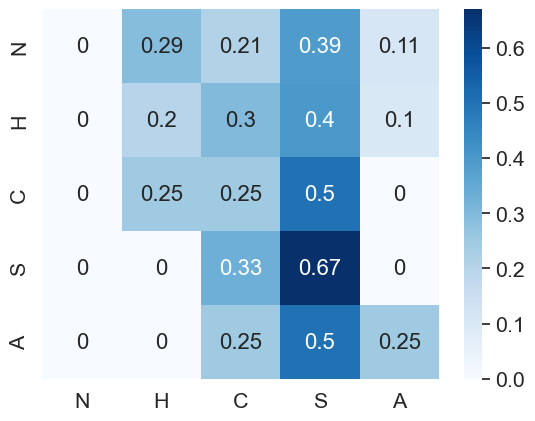

D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dekassla\AppData\Local\Temp\ipykernel_9728\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.70
Metric : TP_Rate, Score :  0.25
Metric : FP_Rate, Score :  0.19
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.12
Metric : F_Macro, Score :  0.08
Confusion Matrix: 
     N     H     C     S    A
N  0.0  0.50  0.42  0.08  0.0
H  0.0  0.57  0.43  0.00  0.0
C  0.0  0.33  0.67  0.00  0.0
S  0.0  0.20  0.80  0.00  0.0
A  0.0  0.75  0.25  0.00  0.0


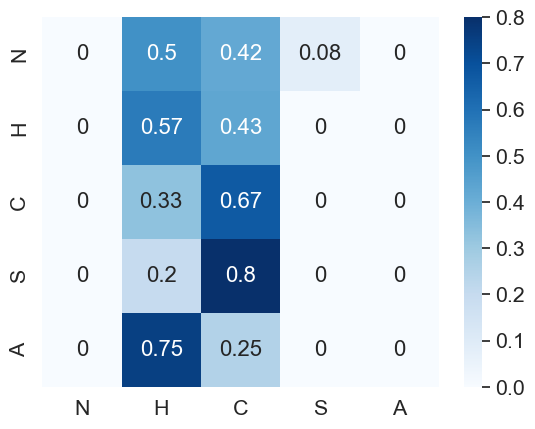

For model:  RF  matrix is:
      D1D2_mean     D1D2_std   D1U1_mean    D1U1_std   D1U2_mean     D1U2_std  \
44   269.286585   260.544219  106.735484   46.835343  380.714286   265.379408   
156  232.180556   210.908001  139.405530  108.146818  364.791667   215.185381   
41   231.575000   276.697091   90.414747   50.506042  367.217593   285.778783   
17   531.346457   455.524382   85.344000   44.256905  618.129032   462.859833   
99   498.546667   551.255052  105.274336   64.969189  601.800000   562.891424   
..          ...          ...         ...         ...         ...          ...   
65   423.459016   371.603639   88.284553   78.231210  511.622951   405.164576   
203  344.518519   230.951393  107.514706   31.067049  452.229630   231.417978   
194  402.006623   303.471624  114.625000   34.750769  516.768212   303.076924   
208  314.046980   162.917871  103.873333   47.275828  416.214765   169.325728   
0    683.060284  1101.553201   96.074380   31.715592  884.215768  1157.264475   



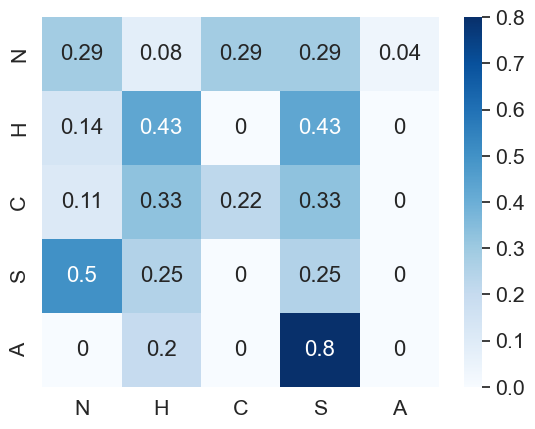

Metric : ACC, Score :  0.74
Metric : TP_Rate, Score :  0.34
Metric : FP_Rate, Score :  0.17
Metric : Precision, Score :  0.33
Metric : F_Measure, Score :  0.33
Metric : F_Micro, Score :  0.27
Metric : F_Macro, Score :  0.24
Confusion Matrix: 
      N     H     C     S     A
N  0.17  0.17  0.17  0.31  0.17
H  0.00  0.57  0.14  0.14  0.14
C  0.14  0.14  0.29  0.29  0.14
S  0.00  0.33  0.00  0.67  0.00
A  0.00  0.00  0.33  0.67  0.00


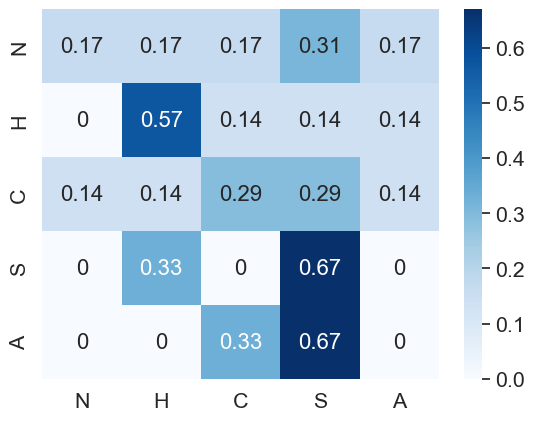

For model:  XGB  matrix is:
      D1D2_mean     D1D2_std   D1U1_mean    D1U1_std   D1U2_mean     D1U2_std  \
66   323.354067   351.861487  121.857143   39.281143  445.325359   360.472058   
241  383.350649   249.835830  101.916129   40.393061  483.844156   255.696633   
61   242.340580   222.251212  100.712230   25.502220  343.007246   226.841466   
5    331.588235   383.468452   87.818713   33.487659  420.529412   388.740079   
195  366.328571   306.178195  108.170616   43.526418  472.642857   303.845874   
..          ...          ...         ...         ...         ...          ...   
173  473.463115   513.030919  102.511211   91.179361  613.355856   540.706932   
160  515.601266  2414.822563  100.396226   43.968259  614.341772  2416.171655   
72   304.671111   241.243516  122.688679  130.610855  442.589623   303.433180   
184  385.373239   279.176722  131.496503   39.819150  517.169014   276.701369   
40   298.350467   291.486592   82.200000   87.777054  378.238318   307.221744   


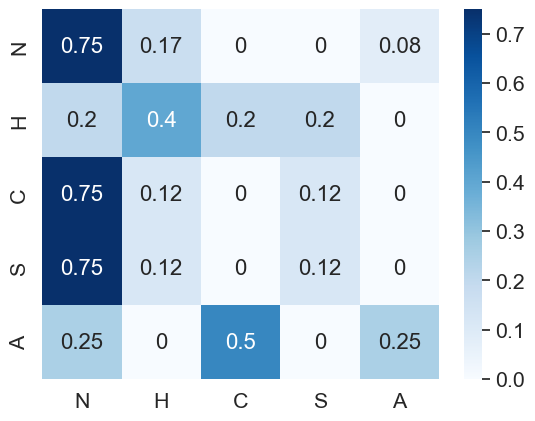

Metric : ACC, Score :  0.79
Metric : TP_Rate, Score :  0.48
Metric : FP_Rate, Score :  0.13
Metric : Precision, Score :  0.50
Metric : F_Measure, Score :  0.49
Metric : F_Micro, Score :  0.59
Metric : F_Macro, Score :  0.46
Confusion Matrix: 
      N     H     C     S    A
N  0.71  0.11  0.11  0.07  0.0
H  0.29  0.57  0.14  0.00  0.0
C  0.40  0.00  0.40  0.00  0.2
S  0.25  0.25  0.00  0.50  0.0
A  0.20  0.00  0.20  0.40  0.2


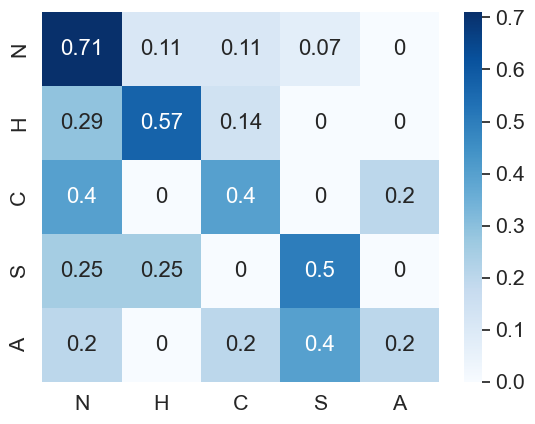

For model:  SVM  matrix is:
      D1D2_mean     D1D2_std   D1U1_mean    D1U1_std    D1U2_mean  \
46   943.079137  1817.011740   95.892193  137.930076  1062.029851   
240  349.081081   223.529323  114.134228   49.030830   461.966216   
143  240.491597   192.016078  129.263598   35.686360   369.050420   
104  975.243655  3851.956368  154.957055   87.415330  1306.641975   
100  499.517241   471.446621  109.698225   55.880134   605.893491   
..          ...          ...         ...         ...          ...   
6    321.190476   352.974442   97.689189   49.390864   418.857143   
139  225.575630   152.235611   96.523013   28.150791   321.840336   
21   266.061728   235.083980  119.776824   39.608730   391.616379   
235  304.615385   574.421764   98.687500   29.632815   403.510490   
19   550.916667   624.051368  183.884298   40.400513   734.550000   

        D1U2_std   TotTime    U1D2_mean     U1D2_std   U1U2_mean  ...  \
46   1901.166499  262286.0   877.787313  1849.768508  945.211679  ... 

C:\Users\dekassla\AppData\Local\Temp\ipykernel_9728\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


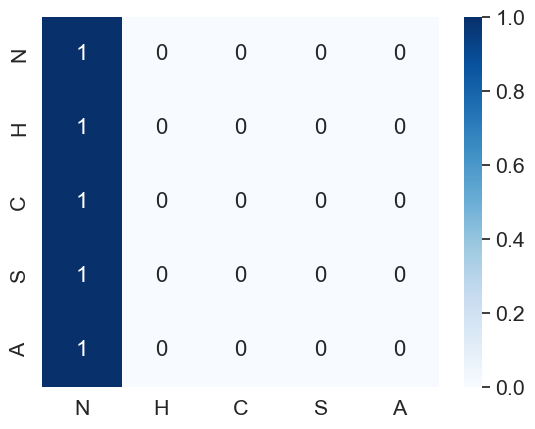

C:\Users\dekassla\AppData\Local\Temp\ipykernel_9728\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.55
Metric : F_Macro, Score :  0.14
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0


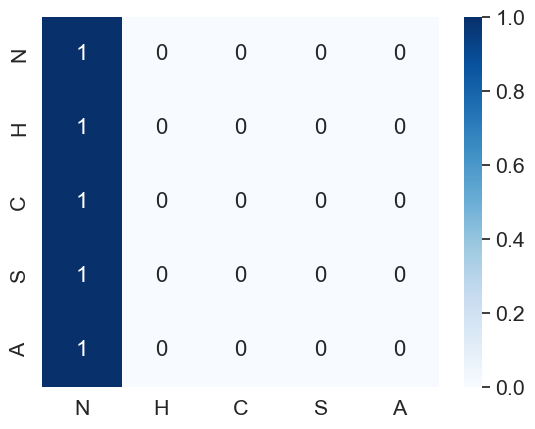

For model:  MLP  matrix is:
      D1D2_mean    D1D2_std   D1U1_mean   D1U1_std   D1U2_mean     D1U2_std  \
227  262.377358  205.587054   89.221675  37.576131  359.212871   205.156857   
90   443.130841  444.850181  120.205742  60.988043  555.519231   446.268503   
206  316.945783  323.657752   81.592814  35.147449  399.945783   323.161235   
173  473.463115  513.030919  102.511211  91.179361  613.355856   540.706932   
139  225.575630  152.235611   96.523013  28.150791  321.840336   154.474005   
..          ...         ...         ...        ...         ...          ...   
242   -1.000000   -1.000000   -1.000000  -1.000000   -1.000000    -1.000000   
8    391.861111  481.375526  109.703448  45.956670  502.048611   472.882287   
141  479.238281  982.774295   93.704167  66.471924  600.907950  1012.901309   
213  347.289855  206.378230  108.223022  40.380750  455.898551   211.044136   
100  499.517241  471.446621  109.698225  55.880134  605.893491   476.977504   

      TotTime   U1D2_me

D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dekassla\AppData\Local\Temp\ipykernel_9728\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.69
Metric : TP_Rate, Score :  0.22
Metric : FP_Rate, Score :  0.19
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.45
Metric : F_Macro, Score :  0.20
Confusion Matrix: 
      N     H     C     S    A
N  0.83  0.00  0.08  0.08  0.0
H  0.71  0.14  0.14  0.00  0.0
C  1.00  0.00  0.00  0.00  0.0
S  0.62  0.25  0.00  0.12  0.0
A  0.80  0.20  0.00  0.00  0.0


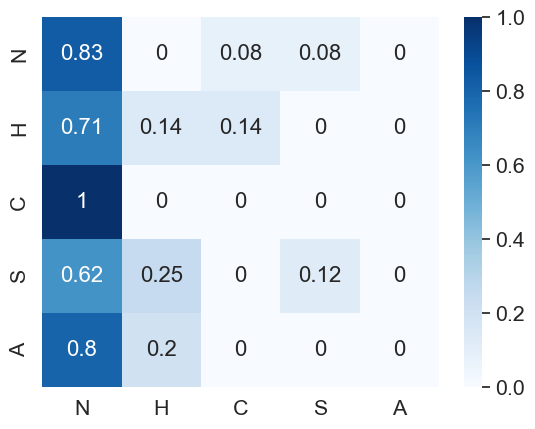

C:\Users\dekassla\AppData\Local\Temp\ipykernel_9728\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.41
Metric : F_Macro, Score :  0.12
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0


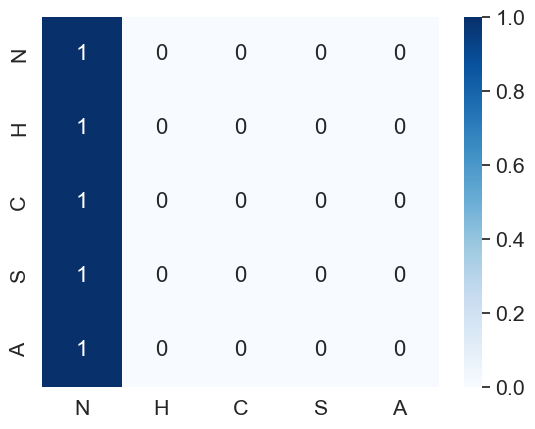

In [120]:
# run all probabilities

model_names = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

for model_name in model_names:
    print("For model: ", model_name, " matrix is:")
    iterate_all_models(model_name)
    iterate_all_models_only_keyfeatures(model_name)

### Binary classification

In [136]:
# initialise more balanced dataframe, to have more equal number of samples for each emotion
import pandas as pd

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Calculate the minimum sample size across all emotion categories
min_sample_size = df_fixed_all['emotionIndex'].value_counts().min()

# Sample data for each emotion category
sampled_data = []
for emotion in emotion_mapping.keys():
    emotion_df = df_fixed_all[df_fixed_all['emotionIndex'] == emotion]
    sampled_emotion_df = emotion_df.sample(n=min_sample_size, random_state=42)
    sampled_data.append(sampled_emotion_df)

# Concatenate the sampled data
dataframe_balanced = pd.concat(sampled_data, axis=0)

# Shuffle the resulting DataFrame
dataframe_balanced = dataframe_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows to verify
print(dataframe_balanced.head())

   userId textIndex emotionIndex  delFreq  leftFreq   TotTime  text_index  \
0     164        FI            H        0         0  102126.0          97   
1      58        FI            H        0         0   36777.0          15   
2      25        FI            N        1         0   82270.0          50   
3      99        FI            C        4         0   76312.0         173   
4     138        FI            H        0         0   51046.0         122   

   user_index idx_start idx_end  ...   U1U2_mean    U1U2_std  typeWith  \
0          -1     18853   18966  ...  260.566372  163.874973       NaN   
1           2      2691    2799  ...  339.268519  288.754304   2 hands   
2          26     10203   10403  ...  410.935000  344.718219   2 hands   
3          86     33776   34020  ...  472.329167  549.966503   2 hands   
4          56     23905   24083  ...  500.629213  503.603306   2 hands   

          typistType                       pcTimeAverage  ageRange  gender  \
0             

In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd



# Define the key features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1U2_std']

# Ensure key features are present in dataframe_balanced
missing_features = [feat for feat in key_features if feat not in dataframe_balanced.columns]
if missing_features:
    raise KeyError(f"Missing features in dataframe_balanced: {missing_features}")

# Filter the DataFrame to include only the specified key features
data_keys = dataframe_balanced[key_features]

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(dataframe_balanced['emotionIndex'])

# Ensure the number of samples in data_keys and emotion_one_hot are the same
if len(data_keys) != len(emotion_one_hot):
    raise ValueError(f"Mismatch in number of samples: data_keys ({len(data_keys)}) and emotion_one_hot ({len(emotion_one_hot)})")

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, emotion_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=(len(key_features),)))
model.add(layers.Dense(int(len(key_features) * 1.5), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.8), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.5), activation="relu"))
model.add(layers.Dense(emotion_one_hot.shape[1], activation="softmax"))

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.1810 - loss: 1.6318 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1966 - loss: 1.6261 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1693 - loss: 1.6244 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2161 - loss: 1.6193 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2318 - loss: 1.6203 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2240 - loss: 1.6243 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2005 - loss: 1.6177 - val_accuracy: 0.2083 - val_loss: 1.6395
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2201 - loss: 1.6176 - val_accuracy: 0.2083 - val_loss

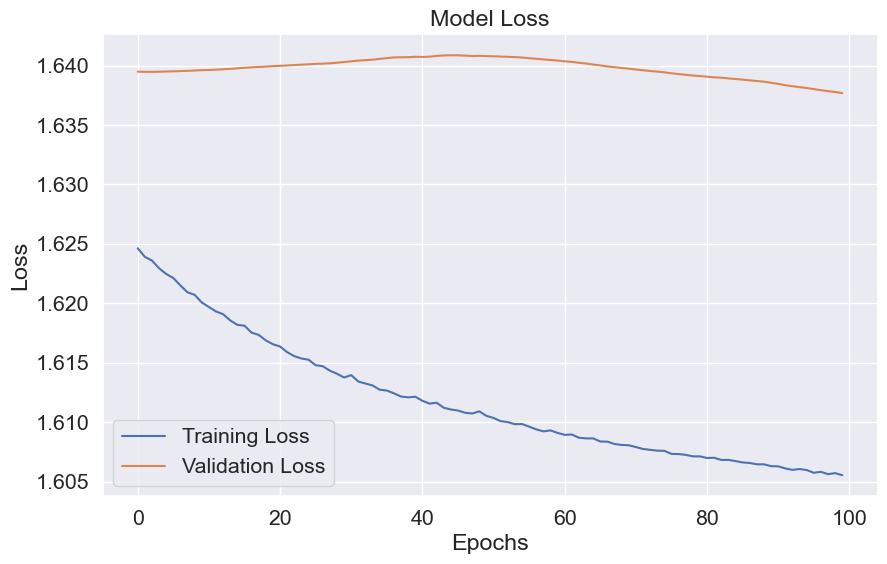

In [138]:
# plot loss

import matplotlib.pyplot as plt

# Extract loss data
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


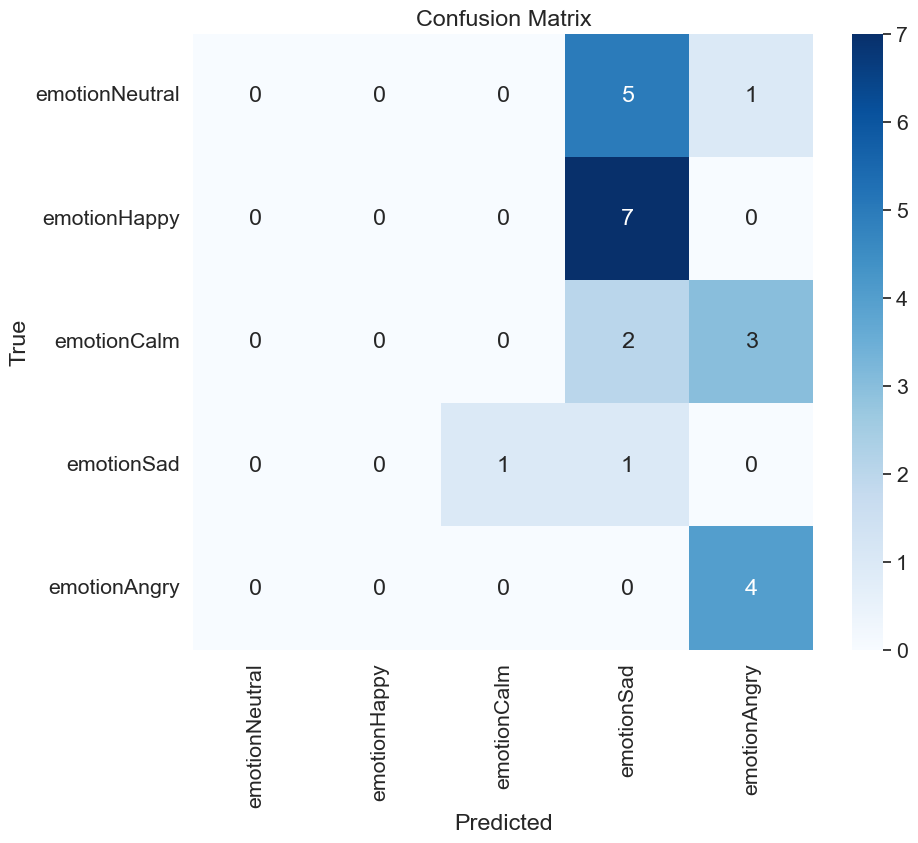

In [139]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the classes for the test set
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels

# Ensure Y_test is a 1D array
if Y_test.ndim == 2:
    Y_test_classes = np.argmax(Y_test.to_numpy(), axis=1)  # Convert one-hot encoded DataFrame to class labels
else:
    Y_test_classes = Y_test.to_numpy()

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [125]:
# ANN with unbalanced dataset


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df_fixed_all_one_hot = df_fixed_all.copy()

# Check if 'emotionIndex' exists in df_fixed_all
if 'emotionIndex' not in df_fixed_all_one_hot.columns:
    raise KeyError("'emotionIndex' column is missing from df_fixed_all")

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Map the emotionIndex to new column names
df_fixed_all_one_hot['emotion'] = df_fixed_all_one_hot['emotionIndex'].map(emotion_mapping)

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(df_fixed_all_one_hot['emotion'])

# Drop the original emotionIndex and emotion columns
df_fixed_all_one_hot = df_fixed_all_one_hot.drop(['emotionIndex', 'emotion'], axis=1)

# Concatenate the one-hot encoded columns to the original DataFrame
df_fixed_all_one_hot = pd.concat([df_fixed_all_one_hot, emotion_one_hot], axis=1)

# Display the first few rows to verify
print(df_fixed_all_one_hot.head())

label_fixed_one_hot = pd.get_dummies(df_fixed_all_one_hot[emotion_mapping.values()])

# Define the number of input features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']
input_shape = (len(key_features),)

# Define the number of output classes (emotions)
num_classes = label_fixed_one_hot.shape[1]

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 1.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.8), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.5), activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))  # Use softmax for multi-class classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
# Check if key_features exist in data_fixed_filter
print("Columns in data_fixed_filter:", data_fixed_filter.columns.tolist())

# Ensure key_features are present in data_fixed_filter
missing_features = [feat for feat in key_features if feat not in data_fixed_filter.columns]
if missing_features:
    raise KeyError(f"Missing features in data_fixed_filter: {missing_features}")

data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

   userId textIndex  delFreq  leftFreq   TotTime  text_index  user_index  \
0     100        FI        8         1  192762.0           0           0   
1     100        FI       11         0   99463.0           1           0   
2     113        FI       10         0   84265.0           2           1   
3     113        FI        7         0   78186.0           3           1   
4     113        FI        9         0   48354.0           4           1   

  idx_start idx_end                                           sentence  ...  \
0         0     282  once there was a cat and a mouse. usually , ca...  ...   
1       283     422  We can not help falling in love with cute and ...  ...   
2       423     656  Once there was a cat and a mouse\u0010. Usaual...  ...   
3       657     840  Beautiful nature and calm music are always rel...  ...   
4       841     978  We can not help falling in love with cute and ...  ...   

   ageRange  gender   status              degree  country  emotionAn

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403 (1.57 KB)

 Trainable params: 403 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Columns in data_fixed_filter: ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3534 - loss: 1.5856 - val_accuracy: 0.5510 - val_loss: 1.5650
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4671 - loss: 1.5730 - val_accuracy: 0.5510 - val_loss: 1.5502
Epoch 3/100
7/7 ━━━━━━━━━━

In [126]:
# 2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df_fixed_all_one_hot = df_fixed_all.copy()

# Check if 'emotionIndex' exists in df_fixed_all
if 'emotionIndex' not in df_fixed_all_one_hot.columns:
    raise KeyError("'emotionIndex' column is missing from df_fixed_all")

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Map the emotionIndex to new column names
df_fixed_all_one_hot['emotion'] = df_fixed_all_one_hot['emotionIndex'].map(emotion_mapping)

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(df_fixed_all_one_hot['emotion'])

# Drop the original emotionIndex and emotion columns
df_fixed_all_one_hot = df_fixed_all_one_hot.drop(['emotionIndex', 'emotion'], axis=1)

# Concatenate the one-hot encoded columns to the original DataFrame
df_fixed_all_one_hot = pd.concat([df_fixed_all_one_hot, emotion_one_hot], axis=1)

# Display the first few rows to verify
print(df_fixed_all_one_hot.head())

label_fixed_one_hot = pd.get_dummies(df_fixed_all_one_hot[emotion_mapping.values()])

# Define the number of input features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']
input_shape = (len(key_features),)

# Define the number of output classes (emotions)
num_classes = label_fixed_one_hot.shape[1]

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 0.8), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.2), activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))  # Use softmax for multi-class classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
# Check if key_features exist in data_fixed_filter
print("Columns in data_fixed_filter:", data_fixed_filter.columns.tolist())

# Ensure key_features are present in data_fixed_filter
missing_features = [feat for feat in key_features if feat not in data_fixed_filter.columns]
if missing_features:
    raise KeyError(f"Missing features in data_fixed_filter: {missing_features}")

data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

   userId textIndex  delFreq  leftFreq   TotTime  text_index  user_index  \
0     100        FI        8         1  192762.0           0           0   
1     100        FI       11         0   99463.0           1           0   
2     113        FI       10         0   84265.0           2           1   
3     113        FI        7         0   78186.0           3           1   
4     113        FI        9         0   48354.0           4           1   

  idx_start idx_end                                           sentence  ...  \
0         0     282  once there was a cat and a mouse. usually , ca...  ...   
1       283     422  We can not help falling in love with cute and ...  ...   
2       423     656  Once there was a cat and a mouse\u0010. Usaual...  ...   
3       657     840  Beautiful nature and calm music are always rel...  ...   
4       841     978  We can not help falling in love with cute and ...  ...   

   ageRange  gender   status              degree  country  emotionAn

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

None
Columns in data_fixed_filter: ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2551 - loss: 1.6073 - val_accuracy: 0.3673 - val_loss: 1.5995
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4733 - loss: 1.5990 - val_accuracy: 0.4694 - val_loss: 1.5935
Epoch 3/100
7/7 ━━━━━━━━━━

In [127]:
# 3


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df_fixed_all_one_hot = df_fixed_all.copy()

# Check if 'emotionIndex' exists in df_fixed_all
if 'emotionIndex' not in df_fixed_all_one_hot.columns:
    raise KeyError("'emotionIndex' column is missing from df_fixed_all")

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Map the emotionIndex to new column names
df_fixed_all_one_hot['emotion'] = df_fixed_all_one_hot['emotionIndex'].map(emotion_mapping)

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(df_fixed_all_one_hot['emotion'])

# Drop the original emotionIndex and emotion columns
df_fixed_all_one_hot = df_fixed_all_one_hot.drop(['emotionIndex', 'emotion'], axis=1)

# Concatenate the one-hot encoded columns to the original DataFrame
df_fixed_all_one_hot = pd.concat([df_fixed_all_one_hot, emotion_one_hot], axis=1)

# Display the first few rows to verify
print(df_fixed_all_one_hot.head())

label_fixed_one_hot = pd.get_dummies(df_fixed_all_one_hot[emotion_mapping.values()])

# Define the number of input features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']
input_shape = (len(key_features),)

# Define the number of output classes (emotions)
num_classes = label_fixed_one_hot.shape[1]

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 2.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 1.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.5), activation="relu"))
model.add(layers.Dense(num_classes, activation="sigmoid"))  # Use softmax for multi-class classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
# Check if key_features exist in data_fixed_filter
print("Columns in data_fixed_filter:", data_fixed_filter.columns.tolist())

# Ensure key_features are present in data_fixed_filter
missing_features = [feat for feat in key_features if feat not in data_fixed_filter.columns]
if missing_features:
    raise KeyError(f"Missing features in data_fixed_filter: {missing_features}")

data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

   userId textIndex  delFreq  leftFreq   TotTime  text_index  user_index  \
0     100        FI        8         1  192762.0           0           0   
1     100        FI       11         0   99463.0           1           0   
2     113        FI       10         0   84265.0           2           1   
3     113        FI        7         0   78186.0           3           1   
4     113        FI        9         0   48354.0           4           1   

  idx_start idx_end                                           sentence  ...  \
0         0     282  once there was a cat and a mouse. usually , ca...  ...   
1       283     422  We can not help falling in love with cute and ...  ...   
2       423     656  Once there was a cat and a mouse\u0010. Usaual...  ...   
3       657     840  Beautiful nature and calm music are always rel...  ...   
4       841     978  We can not help falling in love with cute and ...  ...   

   ageRange  gender   status              degree  country  emotionAn

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 27)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 5)              │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887 (3.46 KB)

 Trainable params: 887 (3.46 KB)

 Non-trainable params: 0 (0.00 B)

None
Columns in data_fixed_filter: ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.2844 - loss: 1.6013 - val_accuracy: 0.3878 - val_loss: 1.5943
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4517 - loss: 1.5880 - val_accuracy: 0.4694 - val_loss: 1.5849
Epoch 3/100
7/7 ━━━━━━━━━━

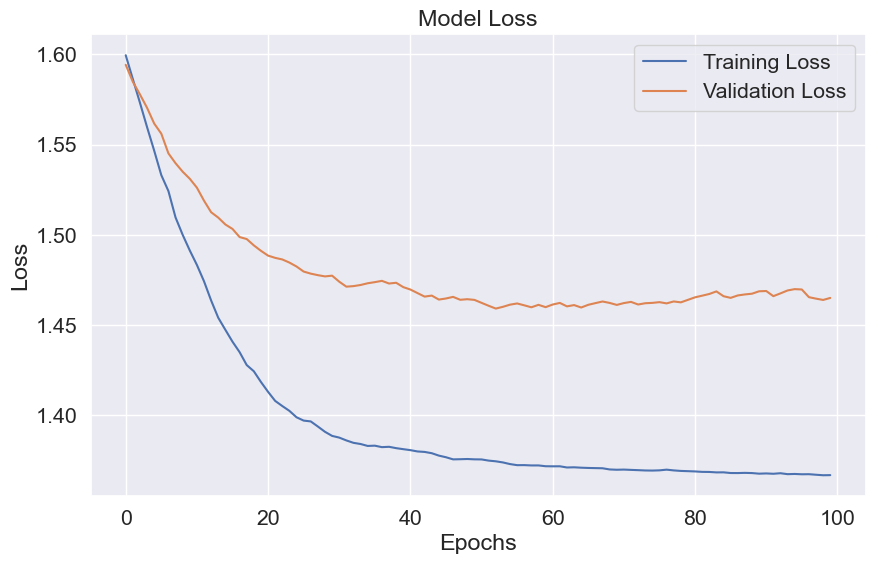

In [128]:
# plot loss

import matplotlib.pyplot as plt

# Extract loss data
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002314BC75630> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002314BC75630> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


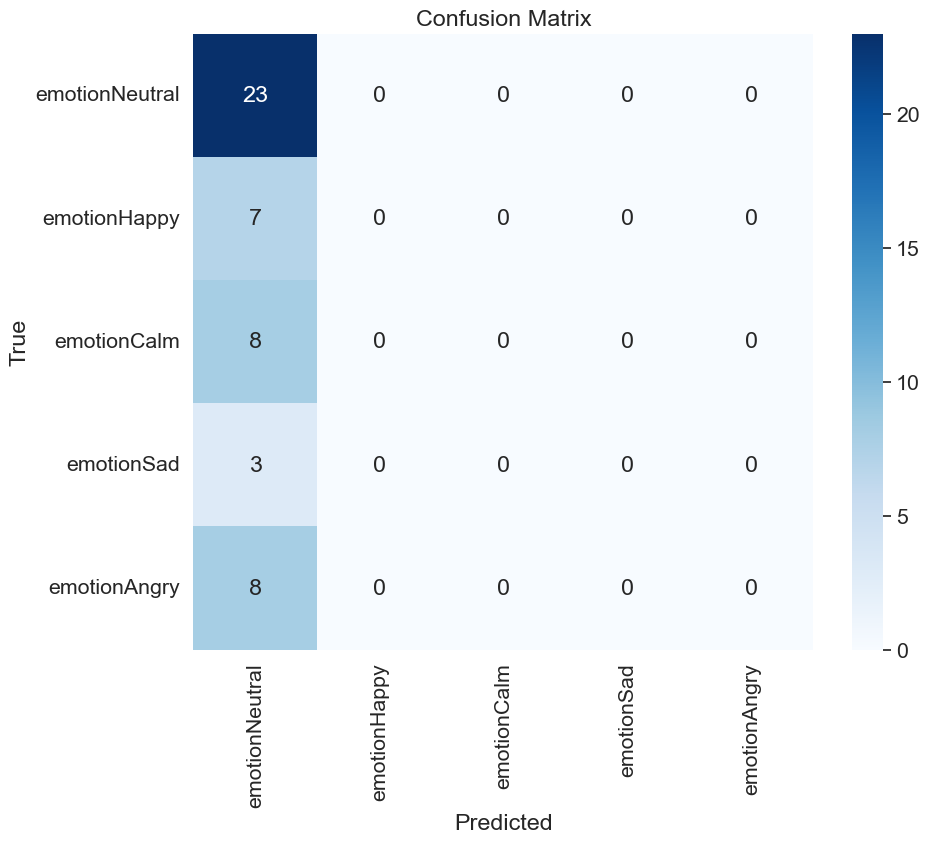

In [129]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the classes for the test set
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels

# Ensure Y_test is a 1D array
if Y_test.ndim == 2:
    Y_test_classes = np.argmax(Y_test.to_numpy(), axis=1)  # Convert one-hot encoded DataFrame to class labels
else:
    Y_test_classes = Y_test.to_numpy()

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Class distribution in Y_train:
emotionNeutral    97
emotionHappy      29
emotionCalm       23
emotionSad        29
emotionAngry      16
dtype: int64
Class distribution in Y_test:
emotionNeutral    23
emotionHappy       7
emotionCalm        8
emotionSad         3
emotionAngry       8
dtype: int64
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Sample predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


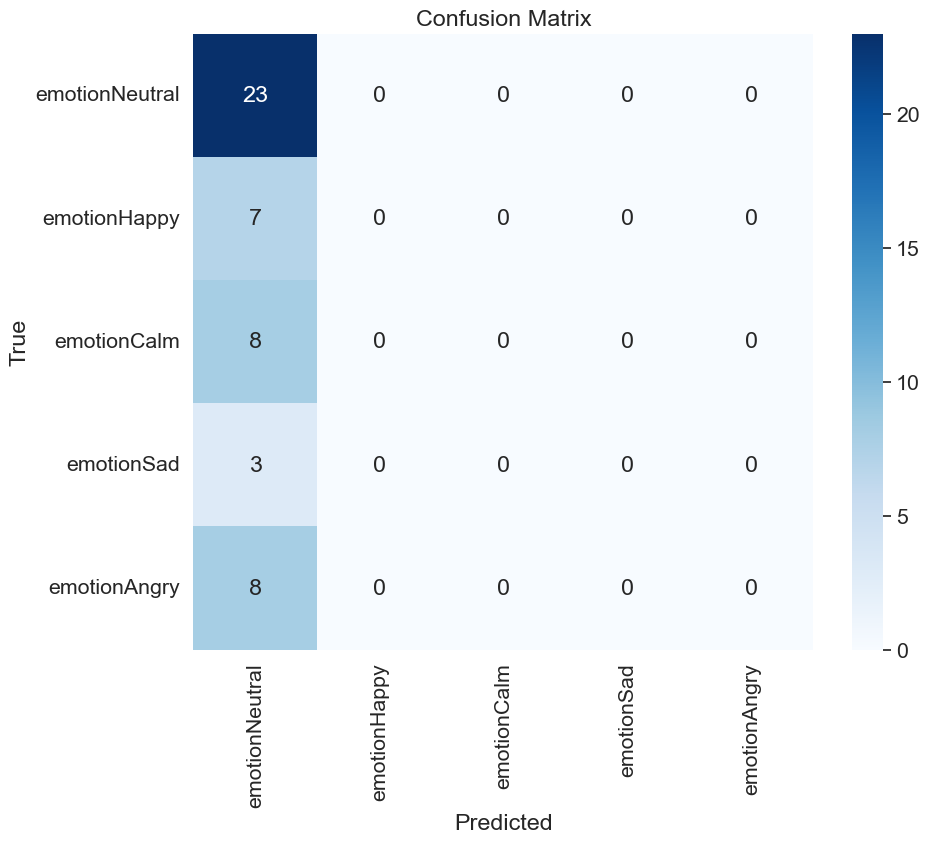

In [130]:
# Print class distribution in the training set
print("Class distribution in Y_train:")
print(Y_train.sum(axis=0))

# Print class distribution in the test set
print("Class distribution in Y_test:")
print(Y_test.sum(axis=0))

# Print a sample of model predictions
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)
print("Sample predictions:", Y_pred_classes[:20])

# Ensure Y_test is a 1D array
Y_test_classes = np.argmax(Y_test.to_numpy(), axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [131]:
import pandas as pd

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Sample DataFrame
# df_fixed_all = pd.DataFrame({
#     'emotionIndex': ['N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A']
# })

# Count the occurrences of each emotion
emotion_counts = df_fixed_all['emotionIndex'].value_counts()

# Map the counts to emotion names
emotion_counts_named = emotion_counts.rename(index=emotion_mapping)

# Print the counts
print(emotion_counts_named)

emotionNeutral    120
emotionHappy       36
emotionSad         32
emotionCalm        31
emotionAngry       24
Name: emotionIndex, dtype: int64


In [132]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Convert labels to one-hot encoding
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}


label_fixed_one_hot = pd.get_dummies(df_fixed_all.emotionIndex.map(emotion_mapping))

# Define the number of input features
input_shape = (len(key_features),)

# Define the number of output classes (emotions)
num_classes = label_fixed_one_hot.shape[1]

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 0.8), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.6), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.1), activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))  # Use softmax for multi-class classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.1690 - loss: 1.6496 - val_accuracy: 0.0612 - val_loss: 1.6522
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1464 - loss: 1.6459 - val_accuracy: 0.0612 - val_loss: 1.6357
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1599 - loss: 1.6256 - val_accuracy: 0.0816 - val_loss: 1.6242
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1421 - loss: 1.6161 - val_accuracy: 0.1020 - val_loss: 1.6115
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2011 - loss: 1.6072 - val_accuracy: 0.2449 - val_loss: 1.5976
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3097 - loss: 1.5949 - val_accuracy: 0.2857 - val_loss: 1.5913
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3749 - loss: 1.5847 - val_accuracy: 0.3878 - val_loss: 1.5826
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3967 - loss: 1.5753 - val_accuracy: 0.4694 - val_

In [133]:
# emotion count 

import pandas as pd

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Sample DataFrame
# df_fixed_all = pd.DataFrame({
#     'emotionIndex': ['N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A']
# })

# Count the occurrences of each emotion
emotion_counts = df_fixed_all['emotionIndex'].value_counts()

# Map the counts to emotion names
emotion_counts_named = emotion_counts.rename(index=emotion_mapping)

# Print the counts
print(emotion_counts_named)

emotionNeutral    120
emotionHappy       36
emotionSad         32
emotionCalm        31
emotionAngry       24
Name: emotionIndex, dtype: int64


In [134]:
# Map emotions to new column names
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Convert emotionIndex to one-hot encoding with specified column names
label_fixed_one_hot = pd.get_dummies(df_fixed_all.emotionIndex.map(emotion_mapping))

# Display the first few rows to verify
print(label_fixed_one_hot.head())

   emotionAngry  emotionCalm  emotionHappy  emotionNeutral  emotionSad
0             0            0             0               1           0
1             0            0             1               0           0
2             0            0             0               1           0
3             0            1             0               0           0
4             0            0             1               0           0


In [135]:
# false one

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the number of input features
input_shape = (data_fixed_filter.shape[1],)

# Define the number of output classes (emotions)
num_classes = len(label_fixed.unique())

print(label_fixed)

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 0.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.2), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.1), activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']

# Filter the DataFrame to include only the specified key features
data_keys = data_fixed_filter[key_features]
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed, test_size=0.2)
  
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test))

0      0
1      1
2      0
3      2
4      1
      ..
238    0
239    3
240    2
241    0
242    0
Name: emotionIndex, Length: 243, dtype: int64


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 20)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 8)              │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069 (4.18 KB)

 Trainable params: 1,069 (4.18 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_52" is incompatible with the layer: expected axis -1 of input shape to have value 41, but received input with shape (None, 11)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 11), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# wrong because sigmoid cant be applicable?

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define the number of input features
input_shape = (len(key_features),)

# Convert labels to binary if necessary
label_fixed_binary = (label_fixed == 1).astype(int)  # Example: Convert to binary labels

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 0.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.2), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.1), activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))  # Use sigmoid for binary classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="binary_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_binary, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))



CNN

In [ ]:
#comment out
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()

### Binary classification

In [ ]:
## binary classification with XGBoost
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', use_label_encoder=False)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

In [ ]:
## binary classification with Random Forest
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1})
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

In [ ]:
## binary classification with SVM
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

### predict values

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle

# Assuming your preprocessing steps and model loading functions are defined
# Load the CSV file
df = pd.read_csv('data/fixed_dummy_dataset.csv')

# Select a single row (for example, the first row for simplicity)
sample_row = df.iloc[0:1]

# Preprocess the sample_row
# Convert categorical features into numerical features


# Use .loc to safely modify the DataFrame slice
sample_row.loc[:, 'gender'] = (sample_row['gender'] == 'Male').astype(int)
sample_row.loc[:, 'ageRange'] = sample_row['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
sample_row.loc[:, 'degree'] = sample_row['degree'].map({'High School': 1, 'College/University': 2})
sample_row.loc[:, 'pcTimeAverage'] = sample_row['pcTimeAverage'].map({'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
sample_row.loc[:, 'status'] = sample_row['status'].map({'Student': 1, 'Professional': 2})
sample_row.loc[:, 'typeWith'] = sample_row['typeWith'].map({'1 hand': 1, '2 hands': 2})

# Check if 'country' and 'typistType' columns exist before creating dummies
if 'country' in sample_row.columns and 'typistType' in sample_row.columns:
    sample_row = pd.get_dummies(sample_row, columns=['country', 'typistType'])
else:
    print("Columns 'country' and/or 'typistType' do not exist in the DataFrame.")
    
print("now df: ", sample_row)

# Assuming 'emotion' is the label column in your CSV
actual_emotion = sample_row['emotionIndex'].values[0]  # Save the actual emotion for comparison
sample_row = sample_row.drop('emotionIndex', axis=1)  # Drop the label column for prediction

print("after dropping emotion:", sample_row)

# Scale the data
scaler = MinMaxScaler()
sample_row_scaled = scaler.fit_transform(sample_row)

# Load your model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Predict the emotion
predicted_emotion = model.predict(sample_row_scaled)

# Print out the predicted and actual emotion for comparison
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Actual Emotion: {actual_emotion}")

In [ ]:
# note to self: you first have to conduct a cell running the iterate all method, to save model correctly
# Predict the emotion from a CSV file
for model in model_names:
    predictions = predict_emotion('data/fixed_dummy_dataset.csv', f'{model}.pkl')
    print(predictions)

In [ ]:
#predict real csv
# Save the first 5 rows of the dataframe `data_fixed` to a CSV file
data_fixed.head(5).to_csv('data/data_fixed_first_5_rows.csv', index=False)

In [ ]:
for model in model_names:
    predictions = predict_emotion('data/data_fixed_first_5_rows.csv', f'{model}.pkl')
    print(predictions)

## Feature importance

In [ ]:
# data standardization
scaler = MinMaxScaler()
data_fixed = pd.DataFrame(scaler.fit_transform(data_fixed), columns=data_fixed.columns)

#### Chi-squared

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

demo_features = np.array(
    ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status', 'country', 'typistType'])

# Feature extraction
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(data_fixed.loc[:, demo_features].fillna(100).replace(-1, 16),
               pd.cut(data_fixed.D1U2_mean.fillna(0), bins=[0, 372, 445, 573, 4306], labels=[1, 2, 3, 4]).fillna(1))

# Summarize scores
np.set_printoptions(precision=3)
print("Ordered features by importance with their corresponding chi2 score")
print(demo_features[np.argsort(fit.scores_)][::-1])
print(fit.scores_[np.argsort(fit.scores_)][::-1])

#### Correlation coefficients

In [ ]:
importances = data_fixed.apply(lambda x: x.corr(data_fixed.D1U2_mean))
indices = np.argsort(importances)
indices_abs = np.argsort(np.abs(importances))[::-1]
print(importances[indices_abs])

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), importances[indices].index.values)
plt.xlabel('Relative Importance')
plt.show()

#### Information Gain

In [ ]:
from info_gain import info_gain

importances_ig = []
for col in data_fixed.columns:
    importances_ig.append(info_gain.info_gain(data_fixed[col], data_fixed.D1U2_mean))
indices_ig = np.argsort(importances_ig)[::-1]
pd.concat([pd.Series(data_fixed.columns[indices_ig]), pd.Series(np.sort(importances_ig)[::-1])], axis=1).set_index(0)

#### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(data_fixed, data_fixed.D1U2_mean)
mi = pd.Series(mi)
mi.index = data_fixed.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

#### Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, 1)
fit = rfe.fit(data_fixed, label_fixed)

print("Feature Ranking: %s" % fit.ranking_)

In [ ]:
list(data_fixed.columns[fit.ranking_ - 1])

#### SHAP values

In [ ]:
# DF, based on which importance is checked
X_importance = pd.DataFrame(data_fixed, columns=data_fixed.columns)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, max_display=len(data_fixed.columns))

#### RF feature importance

In [ ]:
# fixing RF feature importance

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names):
    """
    Plots the feature importance of a trained Random Forest model.
    
    Parameters:
    - model: The trained Random Forest model.
    - feature_names: A list of names corresponding to the features used by the model.
    """
    # Get the feature importances from the model
    importances = model.feature_importances_
    
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange the feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    
    # Create a bar chart
    plt.figure(figsize=(10, 8))
    plt.title("Feature Importance")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), names)
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()


with open('RF.pkl', 'rb') as file:
    model = pickle.load(file)

plot_feature_importance(model, data_fixed.columns.tolist())

In [ ]:
best_model = 'RF'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()

#### XGB feature importance

In [ ]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()